# Rayleigh Waves Synthetic Spectrograms

In [1]:
## Distributed python packages
import os
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr


from math import radians, log
from wmsan.subfunctions_rayleigh_waves import spectrogram
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "0.1"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Production"

## Make Nice Plots

In [2]:
plt.style.use("ggplot")
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
matplotlib.rcParams['pdf.fonttype'] = 42

## Spectrograms From WW3 Hindcast

This Jupyter Notebook aims at computing spectrograms from oceanographic hindcast WAVEWWATCHIII. This is the sequel of another Notebook entitled "Rayleigh Source of Microseisms" in which the user can save the sources of Rayleigh waves matrix.

[NOTE TO THE USER]

If you haven't run the first notebook with the ```save = True``` variable, please do before continuing. 

In [3]:
## Path to netcdf
path_netcdf = './SDF/'

## Dates
start_date = datetime.datetime(2010, 2, 1, 0, 0, 0)
end_date = datetime.datetime(2010, 2, 9, 0, 0, 0)
dates = np.arange(start_date, end_date, datetime.timedelta(hours=3))

## Spectrogram Computation

We compute spectrograms using equations given by Ardhuin et al. (2011) and Stutzmann et al.(2012).
The previous code computes the equivalent source of the power spectrum of the vertical displacement $SDF(f_s)$ in $\text{m.s}$.
From it, we compute the power spectrum of the vertical **ground** displacement at a station of latitude $\lambda$ and longitude $\phi$ in $\text{m}^2.\text{s}^{-1}$, 
$$F_{\delta}(\lambda, \phi, f_s) = \int_{-\pi/2}^{\pi/2} \int_0^{2\pi} \frac{S_{DF}(f_s)}{R_E sin\Delta} P(f_s) e^{-2\pi f_s\Delta R_E/(UQ)}(R_E^2\cos\phi'd\lambda'd\phi')$$
with
- $Q$: the dissipation quality factor
- $\Delta$: the distance between source and station in km
- $R_E$: Earth's Radius in meters
- $U$: the group velocity of Rayleigh waves in km/s
- $P(f_s)$: the 3D seismic wave propagation effect (from Stutzmann et al. (2012)), adimensional.

We plot the modeled spectrogram at each timestep of the model (3-hour resolution) as:
$$S_{spectrogram}(f_s) = 10log_{10}(\sqrt{F_{\delta}(\lambda, \phi, f_s)})$$

References: 
References: 
- [Stutzmann, E., Ardhuin, F., Schimmel, M., Mangeney, A., & Patau, G. (2012). Modelling long-term seismic noise in various environments. Geophysical Journal International, 191(2), 707-722.](https://academic.oup.com/gji/article/191/2/707/644255)

- [Ardhuin, F., Stutzmann, E., Schimmel, M., & Mangeney, A. (2011). Ocean wave sources of seismic noise. Journal of Geophysical Research: Oceans, 116(C9).](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011JC006952)

- [Longuet-Higgins, M. S. (1950). A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 243(857), 1-35.](https://royalsocietypublishing.org/doi/10.1098/rsta.1950.0012)

- [The WAVEWATCH III® Development Group (WW3DG), 2019: User manual and system documentation of WAVEWATCH III® version 6.07. Tech. Note 333, NOAA/NWS/NCEP/MMAB, College Park, MD, USA, 326 pp. + Appendices.](https://www.weather.gov/sti/coastalact_ww3)


## Spectrogram Plot

We plot here the synthetic spectrogram using the function spectrogram.
This function has 2 mandatory arguments:
- path_to_netcdf : the path to netcdf files computed previously
- dates : date vector computed above

And 5 optional arguments:
- param lon_sta: float, optional, longitude of the station (default=-21.3268) II.BORG 
- param lat_sta: float, optional, latitude of the station (default=64.7474) II.BORG
- param Q: int, optional, attenuation factor constant (default=200)
- param U: int, optional, group velocity of Rayleigh waves constant (default=1800 m/s)
- param P: float,  optional, 3D seismic wave propagation effect (default=1), might be needed for stations located on islands or near ice layers.
    

64it [00:25,  2.51it/s]


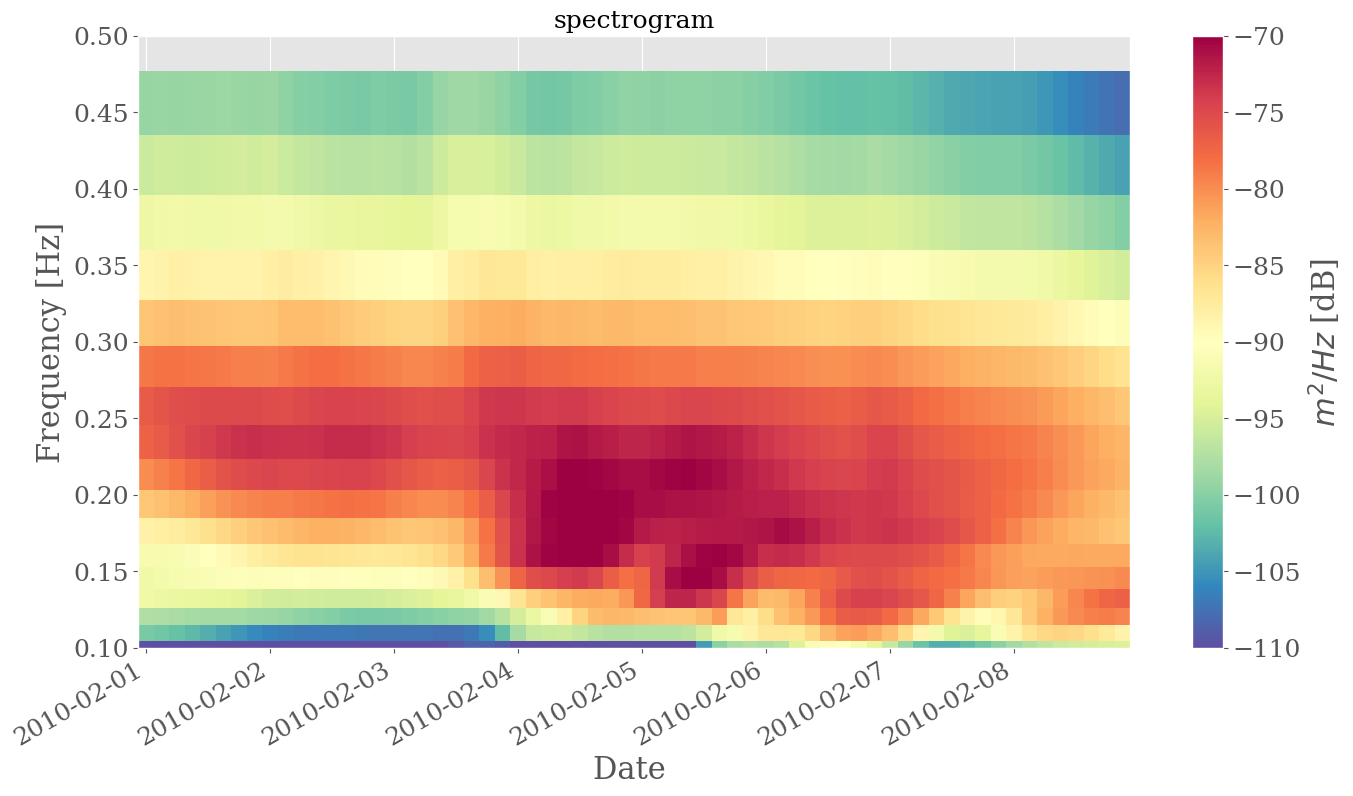

In [4]:
 dates, freq, spectro =  spectrogram(path_netcdf, dates, lon_sta=-149.56525 , lat_sta=-17.5896 , Q=450, U=1800, P=1.9, vmin=-110, vmax= -70)
 
 spectro = 10**(spectro/10)

## Real Data Comparison

Let's compare to real data. Here we computed the spectrogram for station IU.KIP, from the 8-19 March 2008. 

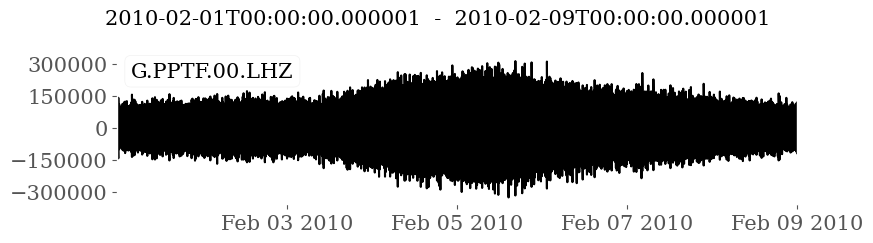

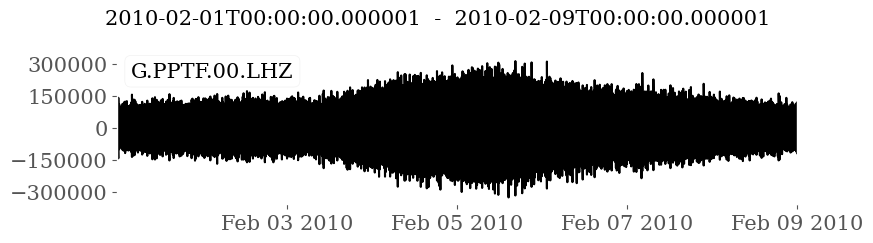

In [5]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Set Dates
t1 = UTCDateTime(start_date)
t2 = UTCDateTime(end_date)

# Request Data
client = Client("IRIS")
st = client.get_waveforms("G", "PPTF", "*", "LHZ", t1, t2, attach_response=True)

st.plot()

In [6]:

# Filter
new_st = st.copy()
new_st.remove_response()
new_st.detrend()

tr_filt = new_st[0].copy()
tr_filt.filter('bandpass', freqmin=0.1, freqmax=0.49, corners=2, zerophase=True)  # Filter in Secondary Microseisms Frequency Range


G.PPTF.00.LHZ | 2010-02-01T00:00:00.000001Z - 2010-02-09T00:00:00.000001Z | 1.0 Hz, 691201 samples

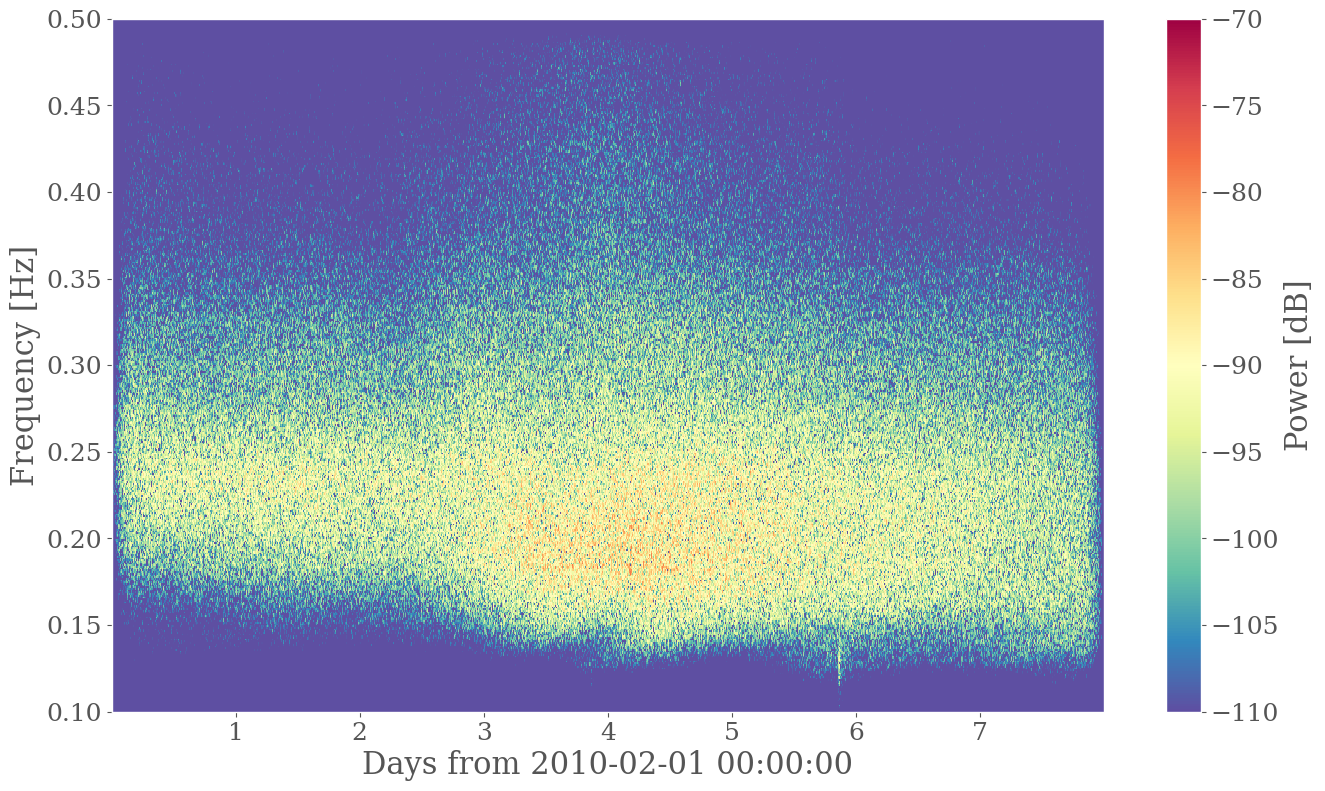

In [7]:
import matplotlib.mlab as mlab

dt = tr_filt.stats.delta
npts = len(tr_filt.data)
fe = 1/dt
nfft = 2**10
noverlap = nfft//2

# Spectrogram
(Px, frequency, t) = mlab.specgram(tr_filt.data, Fs=fe, NFFT=nfft, noverlap=noverlap)
plt.figure(figsize=(16,9))
plt.pcolormesh(t/3600/24, frequency, 10*np.log10(Px), vmin = -110, vmax = -70, shading='auto', cmap='Spectral_r')
plt.colorbar(label='Power [dB]')
plt.ylim(0.1, 0.5)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Days from {}'.format(t1.datetime))
plt.savefig("spectrogram_real.png", dpi=350, bbox_inches='tight')

## Comparison between Modeled and Observed Spectrograms

In [8]:
# Interpolate data in time (3 hours)
import pandas as pd
dt_data = t[1] - t[0]
dates_data = np.arange(start_date, end_date-datetime.timedelta(seconds= dt_data), datetime.timedelta(seconds=dt_data))
new_Px_data  = np.zeros((len(dates), len(frequency)))
dates_data = pd.to_datetime(dates_data)
dates_data = dates_data.floor('h')
for i in range(len(dates)):
    index = dates_data == dates[i]
    Px_date = np.nansum(Px.T[index,:], axis=0)
    new_Px_data[i,:] = np.nansum(Px.T[index,:], axis=0)

In [9]:
# Interpolate synth frequency

spectro_synth_interp = np.zeros((len(dates), len(frequency)))
for i in range(len(dates)):
    spectro_synth_interp[i,:] = np.interp(frequency, freq, spectro[i,:])


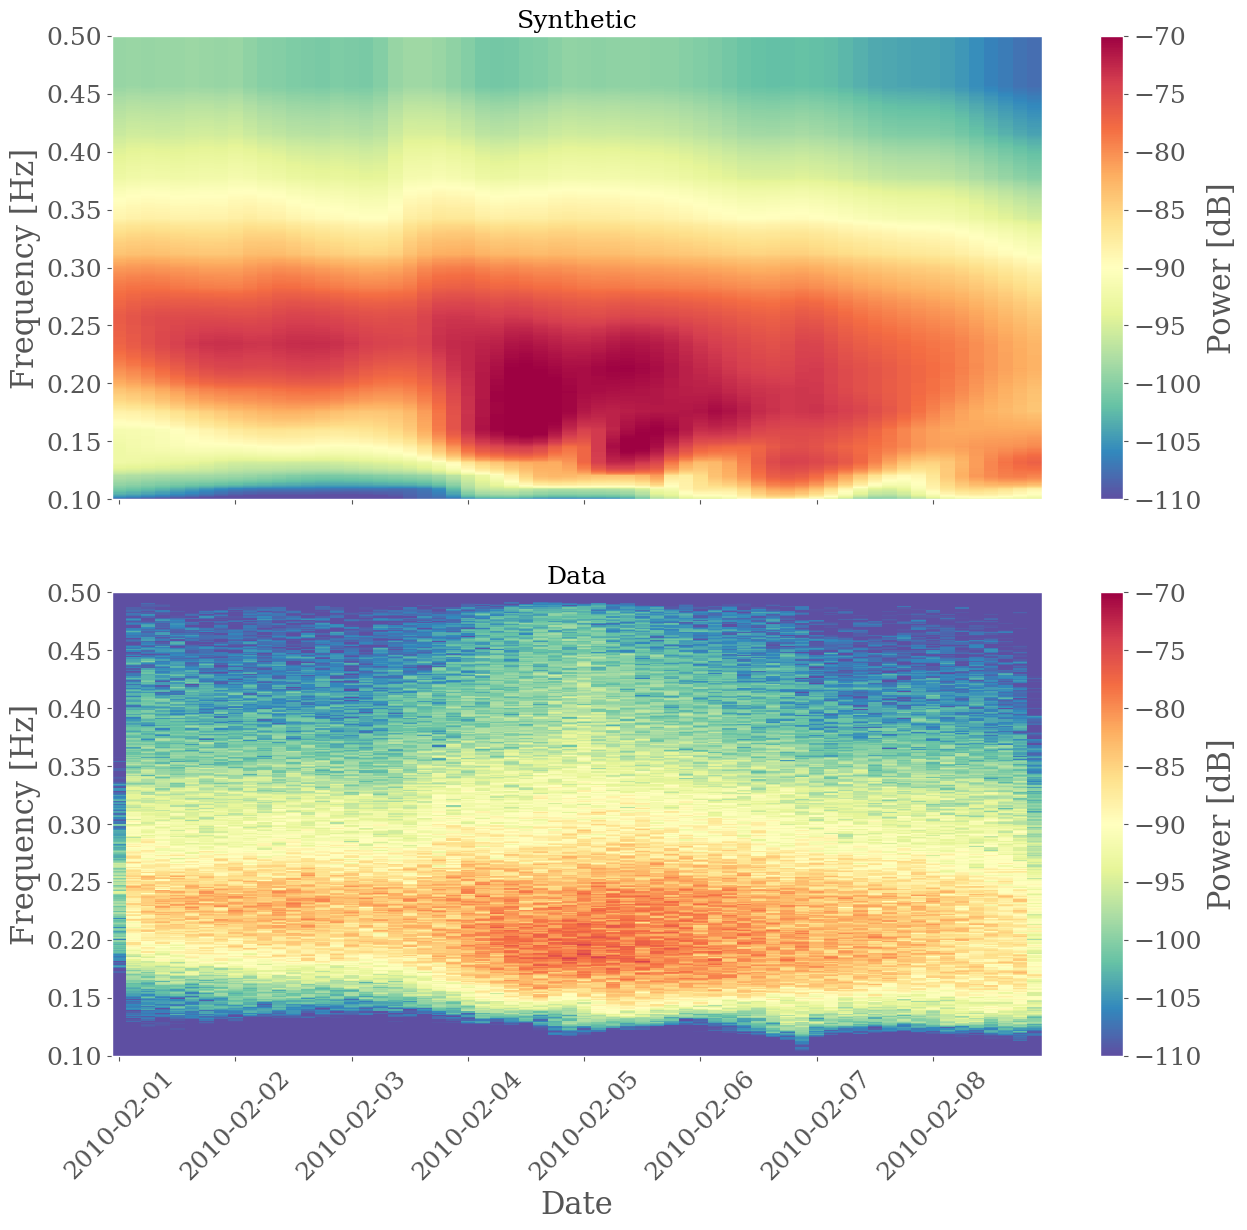

In [10]:
# Plot Interpolated
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharex=True, sharey=True)
ax1 = axs[0]
plt.title('G.DRV')
im1 = ax1.pcolormesh(dates, frequency, 10*np.log10(spectro_synth_interp.T), vmin=-110, vmax=-70, cmap ='Spectral_r')
#plt.yscale('log')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_title("Synthetic")
ax1.set_ylim([0.1, 0.5])
plt.colorbar(im1, ax=ax1,label='Power [dB]')

ax2 = axs[1]
im2 = ax2.pcolormesh(dates, frequency, 10*np.log10(new_Px_data.T), vmin=-110, vmax=-70, cmap ='Spectral_r')
ax2.set_title("Data")
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Date')
ax2.figure.autofmt_xdate(rotation=45, ha='center')
ax2.set_ylim([0.1, 0.5])
plt.colorbar(im2, ax = ax2,label='Power [dB]')
plt.savefig("spectrogram_interpolated.png", dpi=350, bbox_inches='tight')

Correlation 0.8834852164694393
Misfit 9.400347938668283


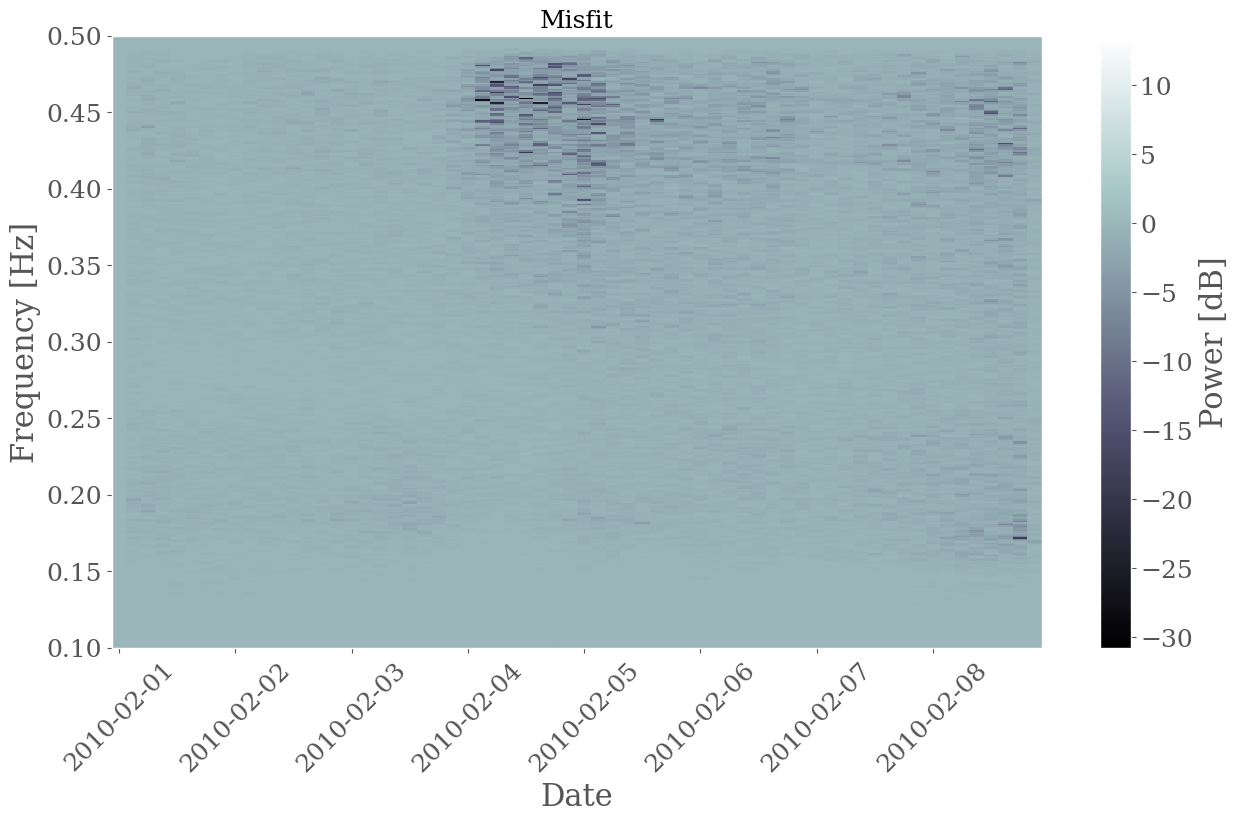

In [11]:
# Compute difference

# Correlation 
data_mean = np.nanmean(new_Px_data)
synth_mean = np.nanmean(spectro)
norm_data = np.sqrt(np.sum((new_Px_data - data_mean)**2, axis=0))
norm_synth = np.sqrt(np.sum((spectro_synth_interp - synth_mean)**2, axis=0))
num = np.nansum((new_Px_data - data_mean)*(spectro_synth_interp - synth_mean), axis=0)
r = np.nanmean(num/(norm_data*norm_synth))
print("Correlation", r)

misfit = np.mean(np.mean(np.abs(new_Px_data-spectro_synth_interp), axis=1)/np.mean(np.abs(new_Px_data), axis=1))
print("Misfit", misfit)

plt.figure(figsize=(15,9))
plt.pcolormesh(dates, frequency, 10*np.log10(np.abs(new_Px_data.T - spectro_synth_interp.T)/np.abs(spectro_synth_interp.T)), cmap ='bone')
plt.gcf().autofmt_xdate(rotation=45, ha='center')
plt.colorbar(label='Power [dB]')
plt.title("Misfit")
plt.xlabel('Date')
plt.ylabel('Frequency [Hz]')
plt.ylim(0.1, 0.5)
plt.savefig("misfit.png", dpi=350, bbox_inches='tight')